In [1]:
import sys
sys.path.insert(0, "../")

# from CustomGymEnv import CustomGymEnv
import torch
from grid2op.Parameters import Parameters
from examples.ppo_stable_baselines.B_train_agent import CustomReward
from lightsim2grid import LightSimBackend
from grid2op.Chronics import MultifolderWithCache
from grid2op.utils import ScoreL2RPN2022
from examples.ppo_stable_baselines.A_prep_env import get_env_seed
import numpy as np
from datetime import datetime

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Copyright (c) 2020-2022 RTE (https://www.rte-france.com)
# See AUTHORS.txt
# This Source Code Form is subject to the terms of the Mozilla Public License, version 2.0.
# If a copy of the Mozilla Public License, version 2.0 was not distributed with this file,
# you can obtain one at http://mozilla.org/MPL/2.0/.
# SPDX-License-Identifier: MPL-2.0
# This file is part of L2RPN Baselines, L2RPN Baselines a repository to host baselines for l2rpn competitions.

import warnings
import copy
import os
import grid2op
import json

from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace, GymEnv

from l2rpn_baselines.PPO_SB3.utils import SB3Agent
from l2rpn_baselines.utils import GymEnvWithRecoWithDN

try:
    from stable_baselines3.common.callbacks import CheckpointCallback
    from stable_baselines3 import PPO
    from stable_baselines3.ppo import MlpPolicy
    _CAN_USE_STABLE_BASELINE = True
except ImportError:
    _CAN_USE_STABLE_BASELINE = False
    class MlpPolicy(object):
        """
        Do not use, this class is a template when stable baselines3 is not installed.
        
        It represents `from stable_baselines3.ppo import MlpPolicy`
        """
    
from l2rpn_baselines.PPO_SB3.utils import (default_obs_attr_to_keep, 
                                           default_act_attr_to_keep,
                                           remove_non_usable_attr,
                                           save_used_attribute)


def get_agent(env,
            name="PPO_SB3",
            iterations=1,
            save_path=None,
            load_path=None,
            net_arch=None,
            logs_dir=None,
            learning_rate=3e-4,
            save_every_xxx_steps=None,
            model_policy=MlpPolicy,
            obs_attr_to_keep=copy.deepcopy(default_obs_attr_to_keep),
            obs_space_kwargs=None,
            act_attr_to_keep=copy.deepcopy(default_act_attr_to_keep),
            act_space_kwargs=None,
            policy_kwargs=None,
            normalize_obs=False,
            normalize_act=False,
            gymenv_class=GymEnv,
            gymenv_kwargs=None,
            verbose=True,
            seed=None,  # TODO
            eval_env=None,  # TODO
            **kwargs):
    
    if not _CAN_USE_STABLE_BASELINE:
        raise ImportError("Cannot use this function as stable baselines3 is not installed")
    
    # keep only usable attributes (if default is used)
    act_attr_to_keep = remove_non_usable_attr(env, act_attr_to_keep)
    
    # save the attributes kept
    if save_path is not None:
        my_path = os.path.join(save_path, name)
    save_used_attribute(save_path, name, obs_attr_to_keep, act_attr_to_keep)

    # define the gym environment from the grid2op env
    if gymenv_kwargs is None:
        gymenv_kwargs = {}
    env_gym = gymenv_class(env, **gymenv_kwargs)
    env_gym.observation_space.close()
    if obs_space_kwargs is None:
        obs_space_kwargs = {}
    env_gym.observation_space = BoxGymObsSpace(env.observation_space,
                                               attr_to_keep=obs_attr_to_keep,
                                               **obs_space_kwargs)
    env_gym.action_space.close()
    if act_space_kwargs is None:
        act_space_kwargs = {}
    env_gym.action_space = BoxGymActSpace(env.action_space,
                                          attr_to_keep=act_attr_to_keep,
                                          **act_space_kwargs)

    if normalize_act:
        if save_path is not None:
            with open(os.path.join(my_path, ".normalize_act"), encoding="utf-8", 
                      mode="w") as f:
                f.write("I have encoded the action space !\n DO NOT MODIFY !")
        for attr_nm in act_attr_to_keep:
            if (("multiply" in act_space_kwargs and attr_nm in act_space_kwargs["multiply"]) or 
                ("add" in act_space_kwargs and attr_nm in act_space_kwargs["add"]) 
               ):
                # attribute is scaled elsewhere
                continue
            env_gym.action_space.normalize_attr(attr_nm)

    if normalize_obs:
        if save_path is not None:
            with open(os.path.join(my_path, ".normalize_obs"), encoding="utf-8", 
                      mode="w") as f:
                f.write("I have encoded the observation space !\n DO NOT MODIFY !")
        for attr_nm in obs_attr_to_keep:
            if (("divide" in obs_space_kwargs and attr_nm in obs_space_kwargs["divide"]) or 
                ("subtract" in obs_space_kwargs and attr_nm in obs_space_kwargs["subtract"]) 
               ):
                # attribute is scaled elsewhere
                continue
            env_gym.observation_space.normalize_attr(attr_nm)
    
    # Save a checkpoint every "save_every_xxx_steps" steps
    checkpoint_callback = None
    if save_every_xxx_steps is not None:
        if save_path is None:
            warnings.warn("save_every_xxx_steps is set, but no path are "
                          "set to save the model (save_path is None). No model "
                          "will be saved.")
        else:
            checkpoint_callback = CheckpointCallback(save_freq=save_every_xxx_steps,
                                                     save_path=my_path,
                                                     name_prefix=name)

    # define the policy
    if load_path is None:
        if policy_kwargs is None:
            policy_kwargs = {}
        if net_arch is not None:
            policy_kwargs["net_arch"] = net_arch
        if logs_dir is not None:
            if not os.path.exists(logs_dir):
                os.mkdir(logs_dir)
            this_logs_dir = os.path.join(logs_dir, name)
        else:
            this_logs_dir = None
                
        nn_kwargs = {
            "policy": model_policy,
            "env": env_gym,
            "verbose": verbose,
            "learning_rate": learning_rate,
            "tensorboard_log": this_logs_dir,
            "policy_kwargs": policy_kwargs,
            **kwargs
        }
        agent = SB3Agent(env.action_space,
                         env_gym.action_space,
                         env_gym.observation_space,
                         nn_kwargs=nn_kwargs,
        )
    else:        
        agent = SB3Agent(env.action_space,
                         env_gym.action_space,
                         env_gym.observation_space,
                         nn_path=os.path.join(load_path, name)
        )
    return agent, env_gym


In [3]:
ENV_NAME = "l2rpn_wcci_2022_dev"
env_name_train = '_'.join([ENV_NAME, "train"])
datetime_now=datetime.now().strftime('%Y-%m-%d_%H-%M')
save_path = "./student"
# name = "CustomGymEnv"
# gymenv_class = CustomGymEnv
name = "GymEnvWithRecoWithDN_{}".format(datetime_now)
gymenv_class = GymEnvWithRecoWithDN # CustomGymEnv
SCOREUSED = ScoreL2RPN2022

train_args = {}

# Utility parameters PPO
train_args["logs_dir"] = "./logs"
train_args["save_path"] = save_path
train_args["name"] = name
train_args["verbose"] = 1
train_args["gymenv_class"] = gymenv_class
train_args["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_args["obs_attr_to_keep"] = ["month", "day_of_week", "hour_of_day", "minute_of_hour",
                                  "gen_p", "load_p", 
                                  "p_or", "rho", "timestep_overflow", "line_status",
                                  # dispatch part of the observation
                                  "actual_dispatch", "target_dispatch",
                                  # storage part of the observation
                                  "storage_charge", "storage_power",
                                  # curtailment part of the observation
                                  "curtailment", "curtailment_limit",  "gen_p_before_curtail",
                                  ]
train_args["act_attr_to_keep"] = ["set_storage", "curtail"]
train_args["iterations"] = 700_000
train_args["learning_rate"] = 1e-4
train_args["net_arch"] = [300, 300, 300]
train_args["gamma"] = 0.999
train_args["gymenv_kwargs"] = {"safe_max_rho": 0.2}
train_args["normalize_act"] = True
train_args["normalize_obs"] = True

train_args["save_every_xxx_steps"] = min(train_args["iterations"] // 10, 100_000)

train_args["n_steps"] = 16
train_args["batch_size"] = 16

p = Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True

env = grid2op.make(ENV_NAME,
                   reward_class=CustomReward,
                   backend=LightSimBackend(),
                   chronics_class=MultifolderWithCache,
                   param=p)

In [4]:
with open("../preprocess_obs.json", "r", encoding="utf-8") as f:
    obs_space_kwargs = json.load(f)
with open("../preprocess_act.json", "r", encoding="utf-8") as f:
    act_space_kwargs = json.load(f)

student, gym_env = get_agent(env,
          obs_space_kwargs=obs_space_kwargs,
          act_space_kwargs=act_space_kwargs,
          **train_args)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [5]:
data = np.load("expert_data/expert_data_2022-06-03_17-29.npz", allow_pickle=True)

### Pre-train the policy

In [5]:
from torch.utils.data.dataset import Dataset, random_split
import torch.nn as nn
import torch

class ExpertDataSet(Dataset):
  def __init__(self, expert_observations, expert_actions):
            self.observations = expert_observations
            self.actions = expert_actions
      
  def __getitem__(self, index):
      return (self.observations[index], self.actions[index])

  def __len__(self):
      return len(self.observations)

In [6]:
def convert_acts(actions):
    converted_acts = []
    for act in actions:
        low = gym_env.action_space.dict_properties["curtail"][0]
        high = gym_env.action_space.dict_properties["curtail"][1]

        curtail = act.curtail.copy()[env.gen_renewable]
        curtail = curtail / (high - low) + low

        low = gym_env.action_space.dict_properties["set_storage"][0]
        high = gym_env.action_space.dict_properties["set_storage"][1]

        storage = act.storage_p.copy() / act_space_kwargs["multiply"]["set_storage"]

        converted_acts.append(np.concatenate((curtail, storage)))
    return converted_acts

In [7]:
def convert_obs(observations):
    converted_obs = []
    g2op_obs = env.reset()
    for obs in observations:
        g2op_obs.from_vect(obs)
        converted_obs.append(gym_env.observation_space.to_gym(g2op_obs))
    return converted_obs

In [8]:
expert_flag      = data.get("expert_flag")
expert_observations = convert_obs(data.get("expert_observations"))
expert_actions      = convert_acts(data.get("expert_actions"))
# expert_observations = [el for i,el in enumerate(expert_observations) if expert_flag[i]==2] # we only keep unsafe case
# expert_actions = [el for i,el in enumerate(expert_actions) if expert_flag[i]==2] # we only keep unsafe case

expert_dataset = ExpertDataSet(expert_observations, expert_actions)

train_size = int(0.8 * len(expert_dataset))

test_size = len(expert_dataset) - train_size

train_expert_dataset, test_expert_dataset = random_split(
    expert_dataset, [train_size, test_size]
)

NameError: name 'data' is not defined

In [11]:
print("total number of elements in the dataset :", len(expert_observations))
print("number of elements in safe mode :", len([el for i,el in enumerate(expert_observations) if expert_flag[i]==0]))
print("number of elements in normal mode :", len([el for i,el in enumerate(expert_observations) if expert_flag[i]==1]))
print("number of elements in unsafe mode :", len([el for i,el in enumerate(expert_observations) if expert_flag[i]==2]))

print("number of elements in test_expert_dataset: ", len(test_expert_dataset))
print("number of elments in train_expert_dataset: ", len(train_expert_dataset))

total number of elements in the dataset : 56937
number of elements in safe mode : 0
number of elements in normal mode : 55133
number of elements in unsafe mode : 1804
number of elements in test_expert_dataset:  11388
number of elments in train_expert_dataset:  45549


In [36]:
def pretrain_agent(
    student,
    batch_size=64,
    epochs=1000,
    learning_rate=1e-4,
    log_interval=10,
    seed=42,
    test_batch_size=64,
):
  torch.manual_seed(seed)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  criterion = nn.MSELoss()

  # Extract initial policy
  model = student.nn_model.policy.to(device)

  def train(model, device, train_loader, optimizer):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      action, _, _ = model(data)
      action_prediction = action.double()

      loss = criterion(action_prediction, target)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print(
          "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch,
            batch_idx * len(data),
            len(train_loader.dataset),
            100.0 * batch_idx / len(train_loader),
            loss.item()
          )
        )

  def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        action, _, _ = model(data)
        action_prediction = action.double()
        test_loss += criterion(action_prediction, target)
    test_loss /= len(test_loader) # Nb batches
    print(f"Test set: Average loss: {test_loss.item():.4f}")

  # Here, we use PyTorch `DataLoader` to our load previously created `ExpertDataset` for training
  # and testing
  train_loader = torch.utils.data.DataLoader(
    dataset=train_expert_dataset, batch_size=batch_size, shuffle=True
  )
  test_loader = torch.utils.data.DataLoader(
    dataset=test_expert_dataset, batch_size=test_batch_size, shuffle=True
  )

  # Define an Optimizer and a learning rate schedule.
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Now we are finally ready to train the policy model.
  for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)
    optimizer.step()
  student.nn_model.policy = model

In [37]:
def eval_agent(agent, env_name, nb_scenario, param, verbose):
    env_val = grid2op.make(env_name, backend=LightSimBackend(), param=param)
    my_score = SCOREUSED(env_val,
                        nb_scenario=nb_scenario,
                        env_seeds=get_env_seed(env_name)[:nb_scenario],
                        agent_seeds=[0 for _ in range(nb_scenario)],
                        verbose=verbose,
                        nb_process_stats=1)
    _, ts_survived, _ = my_score.get(agent)
    return np.array(ts_survived)

Eval before pre-training

In [38]:
ts = eval_agent(student, "l2rpn_wcci_2022_dev_val", 59, p, 1)
ts.mean()

Starts the evaluation of the agent
Start the evaluation of the scores


467.1694915254237

In [ ]:
pretrain_agent(student, batch_size=64, epochs=100000, log_interval=10)

Eval after pre-training

In [43]:
ts = eval_agent(student, "l2rpn_wcci_2022_dev_val", 59, p, 1)
ts.mean()

Starts the evaluation of the agent
Start the evaluation of the scores


466.2881355932203

Check learning curves

In [9]:
import matplotlib.pyplot as plt

In [17]:
data = np.load(os.path.join(save_path,
                            "GymEnvWithRecoWithDN_student_2022-06-08_17-13",
                            "train_test_loss_list.npz"))

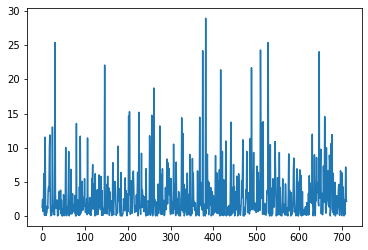

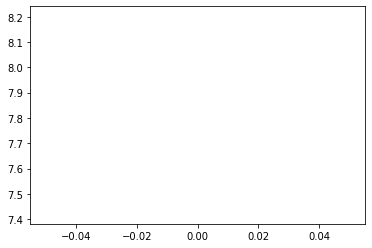

In [18]:
plt.plot(data["train_loss_list"])
plt.show()
plt.plot(data["test_loss_list"])
plt.show()